# Using Readout Layer

This tutorial demonstrate the way of using the readout layer of Speck2e/Speck2f devkit.

## What is readout layer

![readout_layer_intro](../../_static/using_readout_layer/readout_layer.png)

Readout layer is used to **readout the classification results** from the chip. It is **driven by a slow clock**.


- It has 15 channels(category id) and the index of each channel is starting from 1 to 15. In each channel, we count the number of events of the input neuron of each channel at every clock input (clock_slow) (counter is 16bit), all channels computes this parallely.

    And we store the counted value during that **1-clock cycle in a 16bit register**. Then on the next clock cycle we count the events on that neuron and compute the total events during that clock cycle.And we put this in **another register.**

    And then we do this **every clock cycle**, and compute the average of the events over **1, 16 or 32 clock cycle** (this depends on the configuration register). This way we have average(16-bit) of each channel we have.


- Then average signals of all 15-channel goes into **"Find Maximum Average"** block.

    This block finds the average of maximum spiking neuron and outputs the **average information** (which is 16-bit), and it also outputs the **index of the maximum spiking neuron.**


- Then we have another block called **"Average Select"**

    This block also receives the average output of all the channels,and in addition it also has an input called **AVERAGE_SEL** which can be set either through S2P interface or through configuration register. And then this block outputs the average value of the neuron pointed by AVERAGE_SEL<3:0> bits


- And finally we have another block called **"Threshold Compare"**

    This block, similar to others, receives the average otputs of all channels as an input, compares each of these averages (16-bit) of each channel with the threshold(16-bit) set by configuration register and the output of this block is called **threshold_compare<15:1>**
    
    So we have one-bit representation of each channel as threshold_compare. If average output of the channel is bigger than threshold , the corresponding bit of threshold_compare becomes "1"  (average_X[15:0] > threshold<15:0> --> threshold_compare_X=1)

In [1]:
! pip install matplotlib

In [2]:
import torch
import samna
import samnagui
import time
import random
import copy
import socket
import matplotlib.pyplot as plt
import sinabs.backend.dynapcnn.io as sio

from torch import nn
from sinabs.backend.dynapcnn import DynapcnnNetwork
from multiprocessing import Process
from sinabs.from_torch import from_model
from sinabs.layers.pool2d import SumPool2d
from typing import Union
from matplotlib.ticker import MaxNLocator

## 1. Create a 1-layer CNN which can be deployed to the devkit

In [3]:
# init a cnn it has 2 out_channels for a binary classification task
# the input shape of this cnn is (1, 16, 16), output shape of this cnn is (2, 1, 1)

input_shape = (1, 16, 16)

cnn = nn.Sequential(
    SumPool2d(kernel_size=(1, 1)),
    nn.Conv2d(
        in_channels=1,
        out_channels=2,
        kernel_size=(16, 16),
        stride=(1, 1),
        padding=(0, 0),
        bias=False,
    ),
    nn.ReLU(),
)

**assign the CNN layer with a handcraft weight**:

The reason for designing the weights in this way is:

1. We will create a bunch of fake input spikes $X[x_0, x_1, ...x_{T}]$ as the input of the devkit.
2. for any input spike $x_{t}$ with timestamp $t$:

- if $t$, if $t < 0.5 * T$, the $y$ coordinate of spike $x_t$ will be in range [0, 7], i.e. on the top-half of the input region.
- if $t$, if $t > 0.5 * T$, the $y$ coordinate of spike $x_t$ will be in range [8, 15].i.e. on the bottom-half of the input region.

3. Based on this
- the output spike from time $0$ to $0.5 * T$ will all come from output channel #0
- the output spike from time $0.5 * T$ to $T$ will all come from output channel #1

![handcraft_weights](../../_static/using_readout_layer/handcraft_weights.png)

In [4]:
# set handcraft weights for the CNN
weight_ones = torch.ones(1, 8, 16, dtype=torch.float32)
weight_zeros = torch.zeros(1, 8, 16, dtype=torch.float32)

channel_1_weight = torch.cat([weight_ones, weight_zeros], dim=1).unsqueeze(0)
channel_2_weight = torch.cat([weight_zeros, weight_ones], dim=1).unsqueeze(0)
handcraft_weight = torch.cat([channel_1_weight, channel_2_weight], dim=0)

output_cnn_lyr_id = 1
cnn[output_cnn_lyr_id].weight.data = handcraft_weight

**Notice: Speck2e/speck2f devkit neuron index remap**

Since for speck2e/speck2f devkit there is wrong mapping relationship between the output channel index and the readout channel index. We need to define a function to remap the channel index.

**If your devkit is not speck2e/speck2f, then you don't need this remap step**

![neuron index mismatch](../../_static/using_readout_layer/neuron_id_mismatch.png)

In [5]:
def remapping_output_index(
    output_layer: Union[nn.Conv2d, nn.Linear],
) -> Union[nn.Conv2d, nn.Linear]:
    """
    Since the mapping of output channel's index from last cnn layer to the readout layer is not correct
    for speck2e devkit.
    We need to remap the index for the channel's index.
    The mapping law is:
    readout_layer_channel <--> cnn_layer_output_channel
       1  <--> 0
       2  <--> 4
       x  <--> 4(x - 1)
          ...
       15 <--> 56
       Args:
           output_layer: Usually we can use both nn.Linear and nn.Conv2d as the output computational layer of
           a classifier. The shape of weights of those two different type layer are:
           nn.Linear -> [output_channel, input_channel]
           nn.Conv2d -> [output_channel, input_channel, *kernel_size]
       Returns:
           new_output_layer: mapped weight of last layer.
    """
    weights = output_layer.weight.data

    out_channel, input_channel, *rest_dims = weights.size()
    new_out_channel = (out_channel - 1) * 4 + 1

    new_weights = torch.zeros(
        new_out_channel,
        input_channel,
        *rest_dims,
        dtype=weights.dtype,
        device=weights.device,
    )

    for channel_id in range(out_channel):
        new_weights[channel_id * 4, :] = weights[channel_id, :]

    output_layer.weight.data = new_weights

    # change the attributes for the parameter layer
    if isinstance(output_layer, nn.Conv2d):
        output_layer.out_channels = new_out_channel
    elif isinstance(output_layer, nn.Linear):
        output_layer.out_features = new_out_channel
    else:
        raise TypeError(
            f"Expect nn.Conv2d or nn.Linear but got {output_layer.__class__.__name__}"
        )

    return output_layer

In [6]:
# remapping the output layer's
cnn[output_cnn_lyr_id] = remapping_output_index(cnn[output_cnn_lyr_id])

Then we convert the CNN into SNN and trying to deploy it to the devkit

In [7]:
# cnn to snn
snn = from_model(cnn, input_shape=input_shape, batch_size=1).spiking_model
# snn to DynapcnnNetwork
dynapcnn_net = DynapcnnNetwork(snn=snn, input_shape=input_shape, dvs_input=False)

## 2. Two different types of output events from readout layer

There two different types of events can be obtained from the readout layer:

1.[**ReadoutPinValue**](https://synsense-sys-int.gitlab.io/samna/0.48.0/reference/speck2e/event/index.html#samna.speck2e.event.ReadoutPinValue). 

It is generated only when the input spikes to one of the readout layer channel achieves the threshold of the readout layer during one slow-clock cycle. i.e. it is possible that ReadoutPinValue will not be generated at every slow-clock cycle.

It has an attribute named `index` which represents the neuron index with the max average input spikes.

2.[**ReadoutValue**](https://synsense-sys-int.gitlab.io/samna/0.48.0/reference/speck2e/event/index.html#samna.speck2e.event.ReadoutValue) 

It is generated at every slock-clock cycle.

It has an attribute named `value`. It is a number with 21 bits. But setting up different [`output_mod_sel`](https://synsense-sys-int.gitlab.io/samna/reference/speck2e/configuration/index.html?highlight=output_mode_sel#samna.speck2e.configuration.ReadoutConfig.output_mode_sel) this number could have different meaning.


|output_mode_sel  |bit[20]     |bit[19:16]                   |bit[15:0]                            |
|:-               |:-          |:-                           |:-                                   |
|0b00             | data valid | neuron index of max average |power down (clock gating)            |
|0b01             | data valid | neuron index of max average |threshold compare output             |
|0b10             | data valid | neuron index of max average |average output of the selected neuron|
|0b11             | data valid | neuron index of max average |average output of max spiking neuron |


In this experiment we use the mode: `0b01`



## 3. Prepare for deployment

To deploy the SNN to the devkit, there are usually 3 parts you need to set up:

1. **Devkit configuration**. It is an instance of the `samna.speckxx.configuration` class. It contains the configuration of the `CNN Layer`, `DVS Layer` and `Readout Layer`, those 3 parts of the devkit configuration are which we most care about.

2. **Samna graph**. It defines how the data flows into and out from the devkit, then we can obtain different type of data that we need from related nodes of the graph.

3. **Visualizer(optional)**. Samna provides a GUI visualizer for us to visualize: 1.the input signal of the devkit. 2.the output of the devkit. 3.the real-time power consumption of the devkit.

In this experiment, the samna graph is defined as below:


![samna graph](../../_static/using_readout_layer/samna_graph.png)

Then we can:

1. Visualize the input of devkit.
2. Get data from readout layer.
3. Get data from last CNN layer.

### Notice

**Make sure your devkit is plugged in your PC when running the experiment codes below**

### 3.1 Create devkit configuration

In [8]:
readout_threshold = 1

# init devkit config
devkit_cfg = dynapcnn_net.make_config(device="speck2fdevkit:0")

# ========== modify devkit config ==========

"""cnn layers configuration"""
# send to output spike from cnn output layer to readout layer as its input
cnn_output_layer = dynapcnn_net.chip_layers_ordering[-1]
# the readout layer id is fixed for speck2e devkit which is 12
readout_layer = 12
print(f"link output layer: {cnn_output_layer} to readout layer: {readout_layer}")
devkit_cfg.cnn_layers[cnn_output_layer].monitor_enable = True
devkit_cfg.cnn_layers[cnn_output_layer].destinations[0].enable = True
devkit_cfg.cnn_layers[cnn_output_layer].destinations[0].layer = readout_layer

"""readout layer configuration"""
devkit_cfg.readout.enable = True
devkit_cfg.readout.readout_configuration_sel = 0b11
devkit_cfg.readout.output_mode_sel = 0b01
devkit_cfg.readout.low_pass_filter_disable = True
devkit_cfg.readout.threshold = readout_threshold


"""dvs layer configuration"""
# link the dvs layer to the 1st layer of the cnn layers
devkit_cfg.dvs_layer.destinations[0].enable = True
devkit_cfg.dvs_layer.destinations[0].layer = dynapcnn_net.chip_layers_ordering[0]
# merge the polarity of input events
devkit_cfg.dvs_layer.merge = True
# drop the raw input events from the dvs sensor, since we write events to devkit manually
devkit_cfg.dvs_layer.pass_sensor_events = False
# enable monitoring the output from dvs pre-preprocessing layer
devkit_cfg.dvs_layer.monitor_enable = True

Network is valid
link output layer: 0 to readout layer: 12


### 3.2 Construct samna graph

In [9]:
# open devkit
device_names = [each.device_type_name for each in samna.device.get_all_devices()]
print(f"Open device: {device_names[0]}")
devkit = samna.device.open_device(device_names[0])

Open device: Speck2fDevKit


In [10]:
# init the graph
samna_graph = samna.graph.EventFilterGraph()

# init necessary nodes in samna graph
# node for writing fake inputs into devkit
input_buffer_node = samna.BasicSourceNode_speck2f_event_input_event()
# node for reading ReadoutValue
readout_value_buffer_node = samna.BasicSinkNode_speck2f_event_output_event()
# node for reading ReadoutPinValue
pin_value_buffer_node = samna.BasicSinkNode_speck2f_event_output_event()
# node for reading Spike(i.e. the output from last CNN layer)
spike_buffer_node = samna.BasicSinkNode_speck2f_event_output_event()


# build input branch for graph
samna_graph.sequential([input_buffer_node, devkit.get_model_sink_node()])


# build output branches for graph
# branch #1: for the dvs input visualization
_, _, streamer = samna_graph.sequential(
    [devkit.get_model_source_node(), "Speck2fDvsToVizConverter", "VizEventStreamer"]
)
# branch #2: for obtaining the ReadoutValue
_, type_filter_node_readout, _ = samna_graph.sequential(
    [
        devkit.get_model_source_node(),
        "Speck2fOutputEventTypeFilter",
        readout_value_buffer_node,
    ]
)
# branch #3: for obtaining the ReadoutPinValue
_, type_filter_node_pin, _ = samna_graph.sequential(
    [
        devkit.get_model_source_node(),
        "Speck2fOutputEventTypeFilter",
        pin_value_buffer_node,
    ]
)
# branch #4: for obtaining the output Spike from cnn output layer
_, type_filter_node_spike, _ = samna_graph.sequential(
    [devkit.get_model_source_node(), "Speck2fOutputEventTypeFilter", spike_buffer_node]
)


# set the streamer nodes of the graph
# tcp communication port for dvs input data visualization
def free_port():
    """
    Determines a free port using sockets.
    """
    free_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    free_socket.bind(('0.0.0.0', 0))
    free_socket.listen(5)
    port = free_socket.getsockname()[1]
    free_socket.close()
    return port
    
# Specify the tcp port of the visualizer
streamer_endpoint = "tcp://0.0.0.0:" + str(free_port())
streamer.set_streamer_endpoint(streamer_endpoint)

# add desired type for filter node
type_filter_node_readout.set_desired_type("speck2f::event::ReadoutValue")
type_filter_node_pin.set_desired_type("speck2f::event::ReadoutPinValue")
type_filter_node_spike.set_desired_type("speck2f::event::Spike")


### 3.3 Set up visualizer

In [11]:
# Visualizer configuration branch of the graph.
visualizer_config, _ = samna_graph.sequential(
    [samna.BasicSourceNode_ui_event(), streamer]  # For generating UI commands
)

In [12]:
# Launch visualizer
gui_process = sio.launch_visualizer(
    receiver_endpoint=streamer_endpoint, disjoint_process=False
)

In [13]:
# start samna graph before using the devkit
samna_graph.start()

# Specify which plot is to be shown in the visualizer
plot1 = samna.ui.ActivityPlotConfiguration(
    image_width=128, image_height=128, title="DVS Layer", layout=[0, 0, 0.5, 0.89]
)
visualizer_config.write([samna.ui.VisualizerConfiguration(plots=[plot1])])

print("now you should see a change on the GUI window!")

now you should see a change on the GUI window!


### 3.4 Set up readout layer's driven slow-clock

As states above, the readout layer of the chip is driven by a slow-clock. So we need to set up the frequency of the slow-clock, it defines the frequency for reading the classifier's result from the devkit.

In [14]:
dk_io = devkit.get_io_module()
slow_clk_freq = 20  # Hz
dk_io.set_slow_clk_rate(slow_clk_freq)
dk_io.set_slow_clk(True)

## 4. Start readout from devkit

### 4.1 Create fake input for devkit

In [15]:
def create_fake_input_events(time_sec: int, data_rate: int = 1000):
    """
    Args:
        time_sec: how long is the input events
        data_rate: how many input events generated in 1 second

        During the first half time, it generates events where y coordinate only in range[0, 7] which means top half
        region of the input feature map.

        Then in the last half of time, it generates events where y coordinate only in range[8, 15] which means bottom
        half region of the input feature map.

    """

    time_offset_micro_sec = 5000  # make the timestamp start from 5000
    time_micro_sec = time_sec * 1000000  # timestamp unit is micro-second
    time_stride = 1000000 // data_rate

    half_time = time_micro_sec // 2

    events = []
    for time_stamp in range(
        time_offset_micro_sec, time_micro_sec + time_offset_micro_sec + 1, time_stride
    ):
        spk = samna.speck2f.event.DvsEvent()
        spk.timestamp = time_stamp
        spk.p = random.randint(0, 1)
        spk.x = random.randint(0, 15)

        if time_stamp < half_time:
            spk.y = random.randint(
                0, 7
            )  # spike located in top half of the input region
        else:
            spk.y = random.randint(
                8, 15
            )  # spike located in bottom half of the input region

        events.append(spk)

    return events

In [16]:
# create fake input events
input_time_length = 3  # seconds
data_rate = 5000
input_events = create_fake_input_events(time_sec=3, data_rate=data_rate)

print(f"number of fake input spikes: {len(input_events)}")

number of fake input spikes: 15001


In [17]:
# estimated slow-clock cycle for processing the input spikes
clock_cycles_esitmated = slow_clk_freq * input_time_length
clock_cycles_esitmated

60

### 4.2 Read the ReadoutPinValue

In [18]:
# to read the ReadoutPinValue, we need to modify the devkit's readout layer's config a little bit
devkit_cfg.readout.monitor_enable = False
devkit_cfg.readout.readout_pin_monitor_enable = True


# then apply the config to devkit
devkit.get_model().apply_configuration(devkit_cfg)
time.sleep(0.1)

In [19]:
# write the fake input into the devkit

# enable & reset the stop-watch of devkit, this is mainly for the timestamp processing for the input&output events.
stop_watch = devkit.get_stop_watch()
stop_watch.set_enable_value(True)
stop_watch.reset()
time.sleep(0.01)

# clear output buffer
pin_value_buffer_node.get_events()
spike_buffer_node.get_events()

# write through the input buffer node
input_time_length = (input_events[-1].timestamp - input_events[0].timestamp) / 1e6
input_buffer_node.write(input_events)
# sleep till all input events is sent and processed
time.sleep(input_time_length + 0.02)

# read the ReadoutPinValue from related buffer node
pin_value_events = pin_value_buffer_node.get_events()

print("You should see the input events through the GUI window!")

You should see the input events through the GUI window!


The estimated clock cycle is 60
Number of ReadoutPinValue events: 60


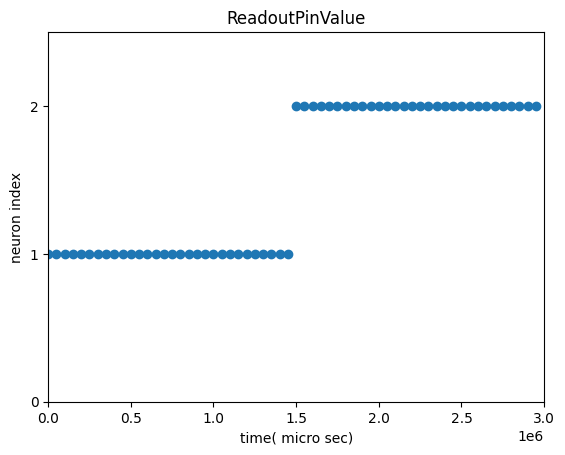

In [20]:
# the number of the ReadoutPinValue should be very close to (or the same as) the estimated clock cycle.
print(f"The estimated clock cycle is {clock_cycles_esitmated}")
print(f"Number of ReadoutPinValue events: {len(pin_value_events)}")

# get the timestamp of the output event
pin_value_timestamp = [each.timestamp for each in pin_value_events]
# shift timestep starting from 0
start_t = pin_value_timestamp[0]
pin_value_timestamp = [each - start_t for each in pin_value_timestamp]

# get the index of the output neuron with maximum output
neuron_id = [each.index for each in pin_value_events]

# plot the output neuron index vs. time
fig, ax = plt.subplots()
ax.scatter(pin_value_timestamp, neuron_id)
ax.set(xlim=(0, 3e6), ylim=(0, 2.5))
ax.set_xlabel("time( micro sec)")
ax.set_ylabel("neuron index")
ax.set_title("ReadoutPinValue")
ax.yaxis.set_major_locator(MaxNLocator(integer=True))  # make y-axis only show integer

### 4.3 Read the ReadoutValue

In [21]:
# to read the ReadoutValue, we need to modify the devkit's readout layer's config also

# you can’t monitor any Spike events from CNN layers or the DVS sensor anymore by setting
# `readout.monitor_enable = True`
devkit_cfg.readout.monitor_enable = True
# disable ReadoutPinvalue reading
devkit_cfg.readout.readout_pin_monitor_enable = False


# then re-apply the config to devkit
devkit.get_model().apply_configuration(devkit_cfg)
time.sleep(0.1)

In [22]:
# write the fake input into the devkit again

# enable & reset the stop-watch of devkit, this is mainly for the timestamp processing for the input&output events.
stop_watch = devkit.get_stop_watch()
stop_watch.set_enable_value(True)
stop_watch.reset()
time.sleep(0.01)

# clear output buffer
readout_value_buffer_node.get_events()

# write through the input buffer node
input_time_length = (input_events[-1].timestamp - input_events[0].timestamp) / 1e6
input_buffer_node.write(input_events)
# sleep till all input events is sent and processed
time.sleep(input_time_length + 0.02)

# read the buffer immediately after the process waiting finished.
# since every slock-clock cycle will append a new ReadoutValue event into the buffer
readout_value_events = readout_value_buffer_node.get_events()

print("You will not see any input events through the GUI window!")

You will not see any input events through the GUI window!


The estimated clock cycle is 60
Number of ReadoutValue events: 61


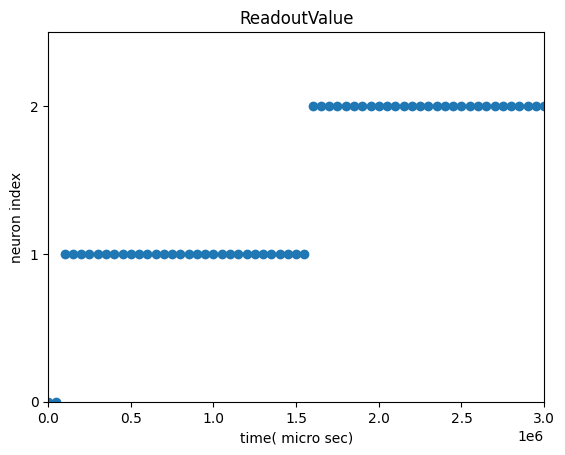

In [23]:
# the number of the ReadoutValue should be very close to (or the same as) the estimated clock cycle.
print(f"The estimated clock cycle is {clock_cycles_esitmated}")
print(f"Number of ReadoutValue events: {len(readout_value_events)}")

# the ReadoutValue event don't have a timestamp, but we know it is generated at every slow-clock cycle
time_each_clock_cycle = 1e6 / slow_clk_freq
readout_value_timestamp = [
    idx * time_each_clock_cycle for idx in range(len(readout_value_events))
]

# shift timestep starting from 0
start_t = readout_value_timestamp[0]
readout_value_timestamp = [each - start_t for each in readout_value_timestamp]

# get the index of the output neuron with maximum output
neuron_id = [(each.value & 0x0F0000) >> 16 for each in readout_value_events]

# plot the output neuron index vs. time
fig, ax = plt.subplots()
ax.scatter(readout_value_timestamp, neuron_id)
ax.set(xlim=(0, 3e6), ylim=(0, 2.5))
ax.set_xlabel("time( micro sec)")
ax.set_ylabel("neuron index")
ax.set_title("ReadoutValue")
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

### 4.4 Check the output from DynapCNN Layer

number of output spikes from DynacpCNN Layer: 15001


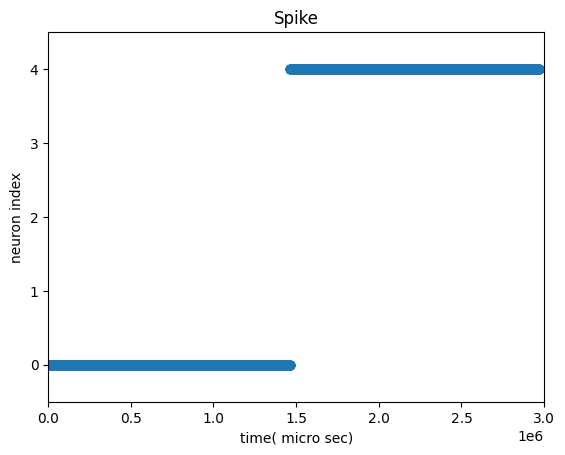

In [24]:
# get the output events from last DynapCNN Layer
dynapcnn_layer_events = spike_buffer_node.get_events()

# eliminate the Spikes come from layer 13
# since the input DVSEvents will be converted into Spikes and output from layer 13
# so the Spikes from layer 13 is the input itself
dynapcnn_layer_events = [each for each in dynapcnn_layer_events if each.layer != 13]

print(f"number of output spikes from DynacpCNN Layer: {len(dynapcnn_layer_events)}")

# get the timestamp of the output event
spike_timestamp = [each.timestamp for each in dynapcnn_layer_events]
# shift timestep starting from 0
start_t = spike_timestamp[0]
spike_timestamp = [each - start_t for each in spike_timestamp]

# get the neuron index of each output spike
neuron_id = [each.feature for each in dynapcnn_layer_events]


# plot the output neuron index vs. time
fig, ax = plt.subplots()
ax.scatter(spike_timestamp, neuron_id)
ax.set(xlim=(0, 3e6), ylim=(-0.5, 4.5))
ax.set_xlabel("time( micro sec)")
ax.set_ylabel("neuron index")
ax.set_title("Spike")
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# we should see the neuron index are 0 and 4 if using speck2e, because of the incorrect map relationship on speck2e devkit

In [25]:
# stop devkit when experiment finished.

gui_process.terminate()
gui_process.join()

samna_graph.stop()
samna.device.close_device(devkit)